# Assignment 1: Analysing and Tracking the Sentiment and Topics on Social Media

## Assignment  Overview: Exploring Sentiment and Topics in Reddit Discussions About Solana 

In this assignment, we analyze public conversations from the r/solana subreddit to understand community sentiment and uncover the main topics people are discussing. Our approach follows a simple and structured process:

- **Data Collection**: Using Reddit’s API, we gathered up to 1,000 top posts from the r/solana subreddit, including the most relevant comments from each post. This provided a rich mix of user opinions and reactions.
  
- **Data Preparation**: Before analysis, the text was cleaned and prepared by removing unnecessary parts like links, repeated words, and auto-generated messages (like “I am a bot”). We combined titles, comments, and post content to get the full picture.

- **Sentiment Analysis**:  
  - We used a pre-built tool to measure how positive or negative each post sounds.  
  - Sentiment scores were then grouped into categories and visualized to show how the community’s mood changes over time.

- **Topic Detection**:  
  - Using a method called topic modeling, we grouped similar posts together based on shared themes.  
  - We visualized these themes using word clouds and interactive diagrams to better understand what people focus on in the community.


## Objective

The goal of this analysis is to discover:
- What people are mostly talking about in the Solana subreddit  
- How the general mood changes across time  
- Whether certain events influence public discussions or emotional tone  




In [1]:
#  !pip install praw
# !pip install pandas
import praw
import prawcore
from time import sleep
from tqdm.notebook import tqdm
import json
import pandas as pd
from datetime import datetime
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
# !pip install langdetect
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
# !pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from itertools import chain
import seaborn as sns
import numpy as np
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
#!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.metrics.pairwise import cosine_similarity
import warnings

# Suppress specific warning categories
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


## 1. Overview

This notebook explores Reddit discussions from r/solana using NLP methods like sentiment analysis and topic modeling. The objective is to uncover public sentiment and trending topics within the subreddit using collected Reddit data.


In [2]:
# Setup Reddit API client
reddit = praw.Reddit(
    client_id="E_7wwJ_0HR-B-XvgWqlMKA",
    client_secret="6GPTLiS36kQXgaJZ0cguFXwU6dBbZA",
    username="cutting_chai1",
    password="Ineedjob@2026",
    user_agent="solana-analysis-bot"
)


## 2. Data Collection

We collected Reddit data from the r/solana subreddit using the PRAW API. Our target was to extract high-quality posts with at least 12 comments, to ensure enough content for topic modeling and sentiment analysis. The dataset includes post titles, self-text, metadata (score, upvotes/downvotes), and all associated comments.

This data was saved in JSON format and converted into a structured DataFrame for analysis.


In [3]:
subreddit_name = "solana"
post_limit = 350
min_comments = 12

collected_data = []
comment_total = 0

subreddit = reddit.subreddit(subreddit_name)
top_posts = subreddit.top(limit=post_limit, time_filter="year")

for submission in tqdm(top_posts, desc="Collecting Top Posts"):
    try:
        submission.comments.replace_more(limit=0)
        comments = [comment.body for comment in submission.comments if isinstance(comment, praw.models.Comment)]

        if len(comments) < min_comments:
            continue

        # Estimate upvotes/downvotes based on Reddit's "score" and "upvote ratio"
        upvotes = int(submission.score * submission.upvote_ratio)
        downvotes = submission.score - upvotes

        collected_data.append({
            "title": submission.title,
            "selftext": submission.selftext,
            "score": submission.score,
            "upvotes": upvotes,
            "downvotes": downvotes,
            "created_utc": datetime.fromtimestamp(submission.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
            "num_comments": submission.num_comments,
            "comments": comments
        })

        comment_total += len(comments)
        sleep(0.1)  # to avoid API limit issues

    except Exception as e:
        print(f"Error with post: {e}")
        continue

# Save to JSON
with open("solana_top_year_300posts_12comments.json", "w", encoding="utf-8") as f:
    json.dump(collected_data, f, indent=2, ensure_ascii=False)





Collected 302 posts with 20342 comments.
Total entries: 20644


In [4]:
with open("solana_top_year_300posts_12comments.json", "r", encoding="utf-8") as f:
    data = json.load(f)

In [5]:
df = pd.DataFrame(data)

In [6]:
total_posts = df.shape[0]
print(f"Total posts collected: {total_posts}")

Total posts collected: 302


In [7]:
# Total comments
total_comments = df["comments"].apply(len).sum()
print(f"Total comments collected: {total_comments}")

Total comments collected: 20342


### Top posts by upvotes

To identify the most popular posts, we sorted the DataFrame by the 'score' column in descending order. The top 10 posts were selected for further analysis. This included examining the post titles, self-text, and associated comments to understand the context and sentiment of the discussions.

In [8]:
# Top posts by score
df.sort_values(by="score", ascending=False)[["title", "score"]].head(5)




,title,score
0,Teach me like I’m 8 years old,3458
1,400K USD while trading meme coins,1840
2,How does one cash out if they have hit a fortu...,1676
3,This belongs to here nowadays very much,1298
4,Don't be this kid ...He rugged his own coin an...,1243


### Top 5 Most Commented Posts

To identify the most engaging content, we sorted the dataset by number of comments and displayed the top 5 posts. These posts often indicate viral or controversial topics within the community.


In [9]:
# Top posts by number of comments
df.sort_values(by="num_comments", ascending=False)[["title", "num_comments"]].head(5)

,title,num_comments
4,Don't be this kid ...He rugged his own coin an...,759
20,Lost all my money trading memecoins.,728
16,i got drained today. all that i’ve worked for ...,714
0,Teach me like I’m 8 years old,711
15,Wallet drained. Trying to figure out how this ...,710


### Combining Text Fields

We combined the post title, body text, and all comments into a single field called `combined_text` for analysis. This holistic view captures full context and sentiment from both the original poster and the community’s responses.


In [ ]:
# Combine text fields
def combine_text(row):
    
return f"{row['title']} {row['selftext']} {' '.join(row['comments'])}"
df["combined_text"] = df.apply(combine_text, axis=1)



### Removing Automatic Bot Messages

Some Reddit comments include auto-generated messages like “I am a bot…” which aren't useful for analysis. We removed these to keep only meaningful user-generated content.


In [11]:
#function to remove common bot disclaimers
def clean_bot_references(text):
    import re
    # Replace "I am a bot" (only the phrase, keep rest of sentence)
    text = re.sub(r"\bi\s*am\s*a\s*bot\b", "", text, flags=re.IGNORECASE)
    # Replace any standalone "bot" word
    text = re.sub(r"\bbot\b", "", text, flags=re.IGNORECASE)
    return text.strip()




In [12]:
# Drop rows with empty combined text
df['combined_text'] = df['combined_text'].apply(clean_bot_references)




In [13]:
print(f"Total posts: {total_posts}")
print(f"Total comments: {total_comments}")
print(f"Total combined entries: {total_posts + total_comments}")

Total posts: 302
Total comments: 20342
Total combined entries: 20644


In [14]:
nltk.download("punkt")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Text Preprocessing Pipeline

Text processing is crucial for preparing raw text data for analysis. We applied several steps to clean and standardize the text, ensuring that our sentiment analysis and topic modeling yield accurate results.
### 2.1. Text Cleaning
- **Lowercasing**: Convert all text to lowercase to ensure uniformity.
- **Removing URLs**: Eliminate hyperlinks to focus on the text content.
- **Removing Special Characters**: Strip out non-alphanumeric characters to clean the text.
- **Removing Extra Spaces**: Normalize whitespace to ensure consistent spacing.
- **Removing Stop Words**: Filter out common words that do not add significant meaning to the text (e.g., "the", "is", "and").
- **Removing Repeated Words**: Eliminate repeated words to reduce noise in the text.


### Tokenization and Frequency Filtering

We applied regex-based tokenization, removed stopwords, and filtered out rare words (that appear only once) as well as overly frequent terms. This helps eliminate noise and focus on meaningful content.


In [15]:
# Preprocessing setup
tokenizer = RegexpTokenizer(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?")
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))

def processText(text, tokenizer, stemmer, stopwords):
    # Tokenize using regex and lowercase
    tokens = re.findall(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?", text.lower())
    
    # Remove short words
    tokens = [token for token in tokens if len(token) > 1]
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stopwords]
    
    # Additional tokenizing (just in case), stem, strip
    lTokens = tokenizer.tokenize(text)
    lTokens = [token.strip() for token in lTokens]
    lStemmedTokens = set([stemmer.stem(tok) for tok in lTokens])
    
    # Final filter
    return [tok for tok in lStemmedTokens if tok not in stopwords and not tok.isdigit()]


### Combining Text Fields

We combined the post title, body text, and all comments into a single field called `combined_text` for analysis. This holistic view captures full context and sentiment from both the original poster and the community’s responses.


In [16]:
# Apply to all combined text
df["tokens"] = df["combined_text"].apply(lambda x: processText(x, tokenizer, stemmer, stop_words))

# Flatten token list to count frequency
all_tokens = [token for sublist in df["tokens"].tolist() for token in sublist]
token_counts = Counter(all_tokens)

# Remove words that appear only once
tokens_filtered = [[tok for tok in tokens if token_counts[tok] > 1] for tokens in df["tokens"]]

# Identify top 20 most frequent words
top_20_words = [word for word, _ in token_counts.most_common(20)]

# Remove those from each token list
df["final_tokens"] = [[tok for tok in tokens if tok not in top_20_words] for tokens in tokens_filtered]

# Convert tokens back to string if needed for LDA/TF-IDF
df["cleaned_string"] = df["final_tokens"].apply(lambda x: " ".join(x))

# Preview
df[["title", "cleaned_string"]].head()


,title,cleaned_string
0,Teach me like I’m 8 years old,raydium leav xdc anoth wanna recoveri reput ni...
1,400K USD while trading meme coins,furrk badli leav greater printer etf brett ano...
2,How does one cash out if they have hit a fortu...,raydium watch bank roughli bunch articl work s...
3,This belongs to here nowadays very much,specif retard worth titl roughli doe concern s...
4,Don't be this kid ...He rugged his own coin an...,watch hack gotcha leav gambler work cunt side ...


In [17]:
df[["title", "final_tokens"]].sample(3)


,title,final_tokens
86,99.99% of meme coins are scams !,"[highlight, bank, hack, photon, gambler, work,..."
262,Why am i receiving this?,"[receiv, sit, print, concern, give, attack, lo..."
204,Making Money or Are We Just Falling for the Hy...,"[signific, bank, badli, trip, power, leav, wor..."


In [18]:
df["combined_text"].sample(3).values

array(["Solana Memecoins are Dead. Solana Memecoins are Dead and I think that's a pity. Yes, there are scams all over the place but the volume was good, the coins that stayed (michi, billy, ponke) made it out with a hardened community.\n\n  \nnow the volume is dead, most coins on dexscreener are either obvious scams or projects with no community at all.\n\nI made good money, hope to find something like this: pure frenzy and degeneracy. WARNING: \n1) IMPORTANT, Read This Post To Keep Your Crypto Safe From Scammers: https://www.reddit.com/r/solana/comments/18er2c8/how_to_avoid_the_biggest_crypto_scams_and/\n2) Do not trust DMs from anyone offering to help/support you with your funds (Scammers)! \n3) Never give out your Seed Phrase and DO NOT ENTER it on ANY websites sent to you.\n4) MODS or Community Managers will NEVER DM you first regarding your funds/wallet.\n\n\n*, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/s

### Language Filtering (English Only)

Since the analysis is designed for English text, we used `langdetect` to remove any posts written in other languages.


In [19]:
def is_english(text):
    try:
        return detect(text) == "en"
    except LangDetectException:
        return False

# Apply and filter only English posts
df["is_english"] = df["combined_text"].apply(is_english)
df = df[df["is_english"] == True].reset_index(drop=True)

print(f"Remaining posts after English filtering: {df.shape[0]}")

Remaining posts after English filtering: 302


## 3. Exploratory Data Analysis (EDA)

### When People Are Most Active

We looked at how often people posted over time. Spikes in activity can show when important things happened.



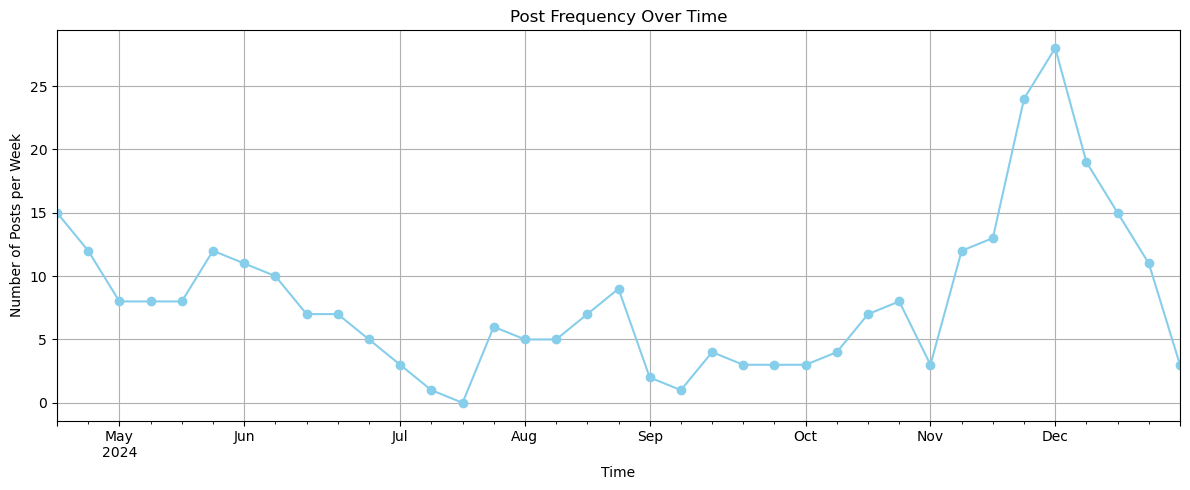

In [20]:
# Convert to datetime if it's not already
df['created_utc'] = pd.to_datetime(df['created_utc'])


plt.figure(figsize=(12, 5))
df.set_index("created_utc").resample("W")["cleaned_string"].count().plot(color="skyblue", marker='o')

plt.title("Post Frequency Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Posts per Week")
plt.grid(True)
plt.tight_layout()
plt.show()


### Word Cloud of Cleaned Text

The following word cloud visualizes the most frequent words across the entire dataset after cleaning. It provides an intuitive sense of dominant terms and themes.


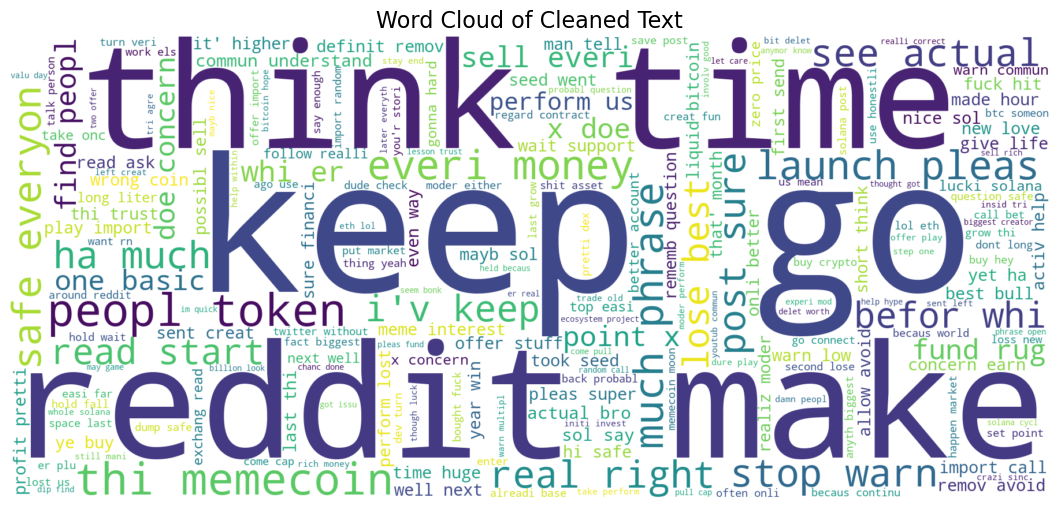

In [21]:


wordcloud = WordCloud(width=1800, height=800, background_color='white').generate(" ".join(df["cleaned_string"]))

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Cleaned Text", fontsize=16)
plt.show()

### Engagement: Score vs. Comment Count

To explore the relationship between post popularity and engagement, we plotted a scatterplot comparing Reddit scores (upvotes – downvotes) and the number of comments.


Text(0, 0.5, 'Comment Count')

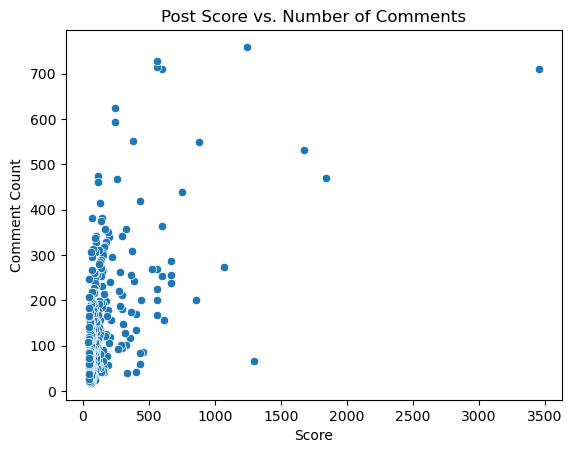

In [22]:
sns.scatterplot(data=df, x='score', y='num_comments')
plt.title("Post Score vs. Number of Comments")
plt.xlabel("Score")
plt.ylabel("Comment Count")


### Corpus Statistics

We computed key statistics like vocabulary size, average post length, and lexical diversity. These provide insight into text quality and guide preprocessing choices.


In [23]:
# Function to compute and visualize corpus statistics
def stats_print(tk_reviews):
    # Step 1: Token-level stats
    words = list(chain.from_iterable([review.split() for review in tk_reviews]))
    vocab = set(words)
    lexical_diversity = len(vocab) / len(words) if len(words) > 0 else 0

    print("Vocabulary size:", len(vocab))
    print("Total number of tokens:", len(words))
    print("Lexical diversity:", round(lexical_diversity, 4))
    print("Total number of reviews:", len(tk_reviews))

    # Step 2: Length analysis
    lens = [len(review.split()) for review in tk_reviews]
    print("Average review length:", round(np.mean(lens), 2))
    print("Max review length:", np.max(lens))
    print("Min review length:", np.min(lens))
    print("Std dev of review length:", round(np.std(lens), 2))

    # Step 3: Histogram of review lengths
    plt.figure(figsize=(10, 5))
    sns.histplot(lens, bins=25, kde=True, color='skyblue')
    plt.title('Distribution of Text Lengths (in Tokens)')
    plt.xlabel('Tokens per Post')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Step 4: Pie chart — Vocabulary vs Total Tokens
    labels = ['Vocabulary Size', 'Total Tokens']
    sizes = [len(vocab), len(words)]
    plt.figure(figsize=(5, 5))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#99ff99'])
    plt.title('Token Composition')
    plt.axis('equal')
    plt.show()

    # Step 5: Top 20 frequent words
    word_freq = Counter(words).most_common(20)
    freq_df = pd.DataFrame(word_freq, columns=["Word", "Frequency"])

    plt.figure(figsize=(12, 5))
    sns.barplot(data=freq_df, x="Word", y="Frequency", palette="mako")
    plt.title("Top 20 Most Frequent Words")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

Vocabulary size: 6698
Total number of tokens: 133755
Lexical diversity: 0.0501
Total number of reviews: 302
Average review length: 442.9
Max review length: 1665
Min review length: 62
Std dev of review length: 283.41


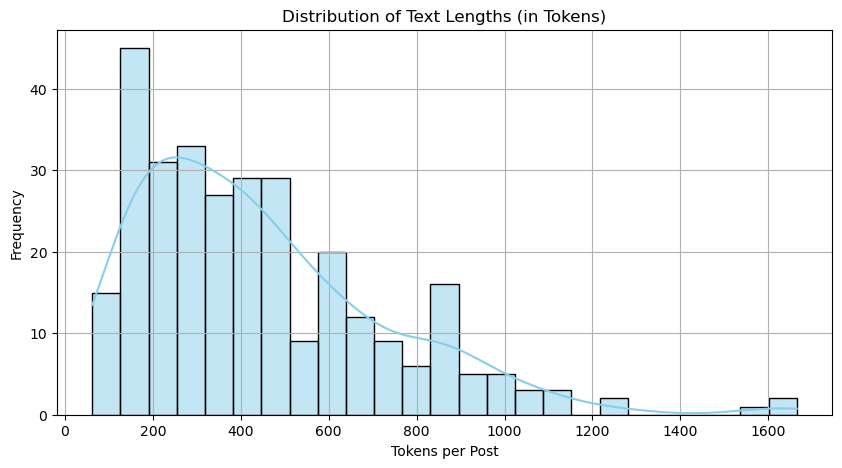

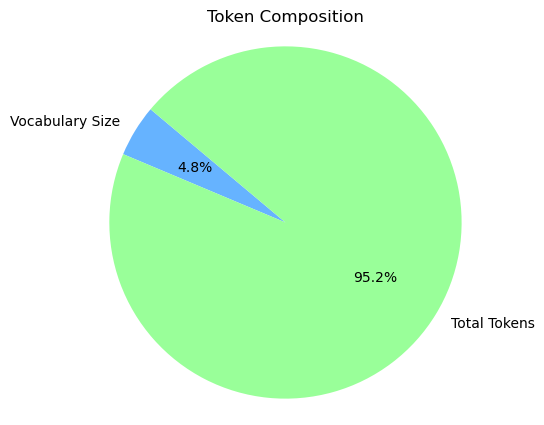

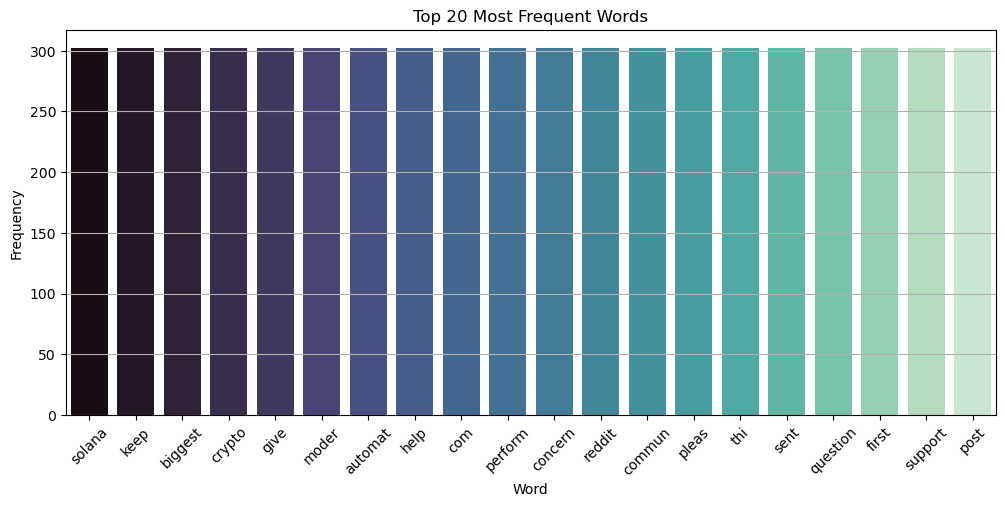

In [24]:
stats_print(df["cleaned_string"].tolist())


### Null Value Check After Preprocessing

We validated that no missing values remain in the processed dataset.


In [25]:
#check if the processed data has null values
print("Missing Values in Processed Data:\n", df.isnull().sum())

Missing Values in Processed Data:
 title             0
selftext          0
score             0
upvotes           0
downvotes         0
created_utc       0
num_comments      0
comments          0
combined_text     0
tokens            0
final_tokens      0
cleaned_string    0
is_english        0
dtype: int64


## 4. Lexicon-Based Sentiment Analysis (VADER)

We use VADER, a lexicon-based sentiment analyzer designed for social media text, to assess the emotional tone of posts. VADER returns compound scores representing the sentiment polarity of each post, along with positive, neutral, and negative sub-scores.


In [26]:
nltk.download("vader_lexicon")

# Initialize VADER
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [27]:
# Apply sentiment scoring to each post
df["vader_scores"] = df["cleaned_string"].apply(sia.polarity_scores)

# Extract compound score
df["compound"] = df["vader_scores"].apply(lambda x: x["compound"])

# Classify sentiment
def classify_vader_sentiment(score):
    if score >= 0.93:
        return "positive"
    elif score <= 0.3:
        return "negative"
    else:
        return "neutral"

df["sentiment"] = df["compound"].apply(classify_vader_sentiment)

# Preview
df[["cleaned_string", "compound", "sentiment"]].head()

,cleaned_string,compound,sentiment
0,raydium leav xdc anoth wanna recoveri reput ni...,0.9952,positive
1,furrk badli leav greater printer etf brett ano...,0.9987,positive
2,raydium watch bank roughli bunch articl work s...,0.9922,positive
3,specif retard worth titl roughli doe concern s...,0.9674,positive
4,watch hack gotcha leav gambler work cunt side ...,0.2437,negative


### Sentiment Distribution
We visualized the distribution of sentiment scores across the dataset. This helps us understand the overall mood of the community and identify any significant trends or shifts in sentiment over time. We also categorized posts into positive, negative, and neutral based on their compound scores. This categorization allows for a more nuanced analysis of community sentiment.

In [28]:
print(df["compound"].describe())

count    302.000000
mean       0.858557
std        0.396193
min       -0.976300
25%        0.956550
50%        0.983350
75%        0.993200
max        0.998700
Name: compound, dtype: float64


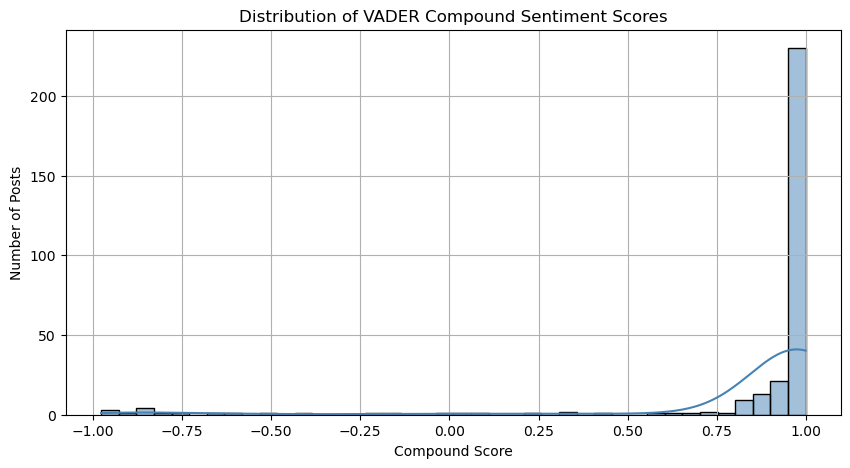

In [29]:
plt.figure(figsize=(10, 5))
sns.histplot(df["compound"], bins=40, kde=True, color="steelblue")
plt.title("Distribution of VADER Compound Sentiment Scores")
plt.xlabel("Compound Score")
plt.ylabel("Number of Posts")
plt.grid(True)
plt.show()

In [30]:
df.groupby("sentiment")["compound"].mean().sort_values(ascending=False)

sentiment
positive    0.982682
neutral     0.809437
negative   -0.545115
Name: compound, dtype: float64

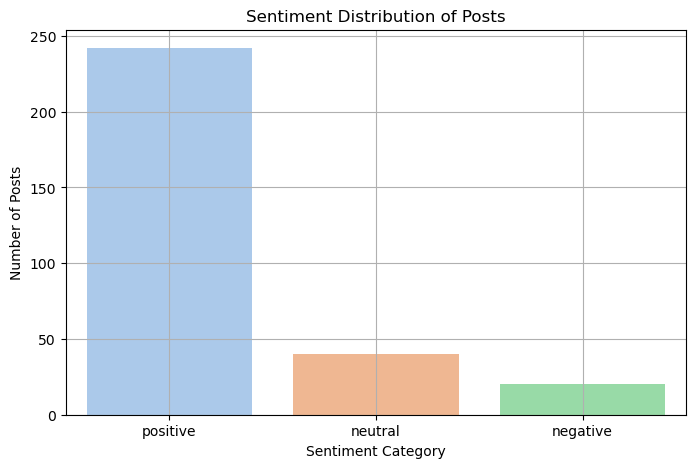

In [31]:


plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="sentiment", palette="pastel", order=["positive", "neutral", "negative"])
plt.title("Sentiment Distribution of Posts")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Posts")
plt.grid(True)
plt.show()


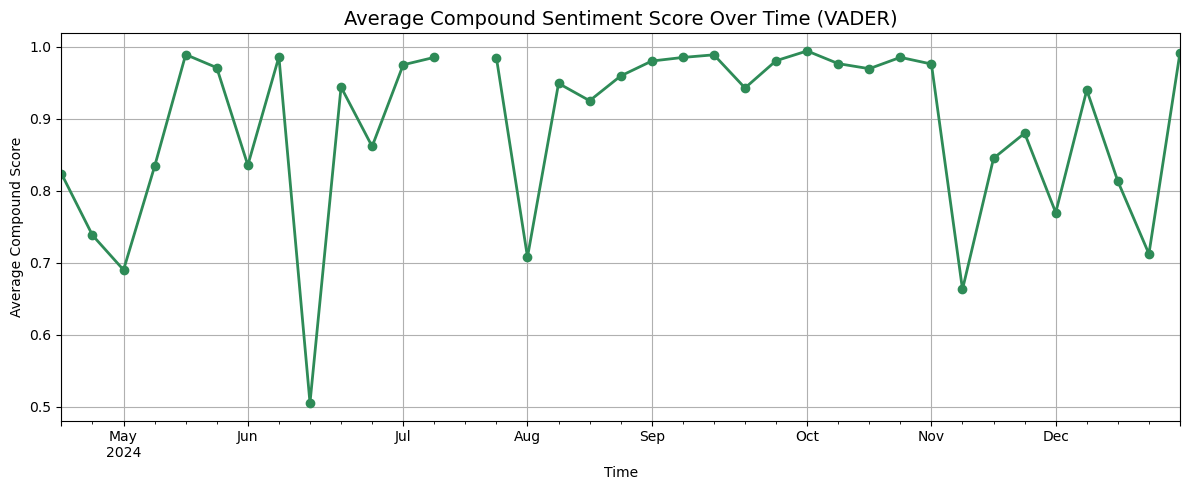

In [32]:
# Ensure datetime format
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Group by week and get mean compound score
compound_trend = df.set_index('created_utc').resample('W')['compound'].mean()

# Plot
plt.figure(figsize=(12, 5))
compound_trend.plot(marker='o', color='seagreen', linewidth=2)

plt.title("Average Compound Sentiment Score Over Time (VADER)", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Average Compound Score")
plt.grid(True)
plt.tight_layout()
plt.show()


## 5. Topic Modeling with LDA

To uncover underlying themes in Reddit discussions, we apply Latent Dirichlet Allocation (LDA) using both CountVectorizer and TF-IDF vectorization. Each model extracts 5 topics based on word co-occurrence patterns.


In [56]:
# ======= Vectorizer & LDA Configuration =======
vectorizer_params = {
    'max_df': 0.9,
    'min_df': 5,
    'stop_words': 'english',
    'max_features': 1000
}

lda_params = {
    'n_components': 5,
    'random_state': 20
}


text_data = df["cleaned_string"]

### LDA with TF-IDF
We also applied TF-IDF vectorization to capture the importance of terms relative to their frequency across documents. The LDA model was trained on this matrix, and the resulting topics were visualized similarly to the CountVectorizer approach. This provides a different perspective on the themes present in the discussions.

In [57]:
# ======= TfidfVectorizer & LDA =======
tfidf_vectorizer = TfidfVectorizer(**vectorizer_params)
dtm_tfidf = tfidf_vectorizer.fit_transform(text_data)

lda_tfidf = LatentDirichletAllocation(**lda_params)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=5, random_state=20)

### LDA with CountVectorizer
We used CountVectorizer to create a document-term matrix, which was then fed into the LDA model. The resulting topics were visualized using word clouds, showing the most significant terms associated with each topic. This helps us understand the main themes discussed in the subreddit.

In [58]:

# ======= CountVectorizer & LDA =======
cv_vectorizer = CountVectorizer(**vectorizer_params)
dtm_cv = cv_vectorizer.fit_transform(text_data)

lda_cv = LatentDirichletAllocation(**lda_params)
lda_cv.fit(dtm_cv)

LatentDirichletAllocation(n_components=5, random_state=20)

In [59]:
def show_topics(model, feature_names, top_n=10):
    for idx, topic in enumerate(model.components_):
        print(f"\n Topic #{idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-top_n - 1:-1]]))



## Comparative Analysis of LDA Models
We compared the results of the LDA models using CountVectorizer and TF-IDF vectorization. This comparison helps us understand how different vectorization methods influence topic extraction and provides insights into the robustness of the identified themes. We also examined the coherence scores of both models to evaluate their performance.

In [60]:
# Display CountVectorizer topics
print("LDA Topics using CountVectorizer:")
show_topics(lda_cv, cv_vectorizer.get_feature_names_out(), 10)



LDA Topics using CountVectorizer:

 Topic #1:
ha make gonna market need buy sol price delet super

 Topic #2:
sol use buy make whi ha know time onli peopl

 Topic #3:
beat mad candl cex chase slowli engag spot etf trump

 Topic #4:
long let term real hold cap play invest pump game

 Topic #5:
meme pump peopl good money memecoin make rug sol remov


In [61]:
# Display TfidfVectorizer topics
print("\nLDA Topics using TfidfVectorizer:")
show_topics(lda_tfidf, tfidf_vectorizer.get_feature_names_out(), 10)


LDA Topics using TfidfVectorizer:

 Topic #1:
chatter confus monthli news mad thread attack remov bs specif

 Topic #2:
chatter confus monthli news mad thread attack remov bs specif

 Topic #3:
chatter confus monthli news mad thread attack remov bs specif

 Topic #4:
sol meme remov buy ha good make token peopl money

 Topic #5:
chatter confus monthli news mad thread attack remov bs specif


In [62]:
def plot_topic_word_bars(lda_model, vectorizer, n_top_words=10, title_prefix="Topic"):
    feature_names = vectorizer.get_feature_names_out()
    
    for topic_idx, topic in enumerate(lda_model.components_):
        top_word_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_word_indices]
        top_weights = topic[top_word_indices]

        # Construct title from top 5 words
        topic_label = ", ".join(top_words[:5])

        # Plot
        plt.figure(figsize=(10, 4))
        sns.barplot(x=top_weights, y=top_words, palette="viridis")
        plt.title(f"{title_prefix} {topic_idx + 1}: {topic_label}")
        plt.xlabel("Word Importance")
        plt.ylabel("Top Words")
        plt.grid(True)
        plt.tight_layout()
        plt.show()





In [63]:
def plot_top_words_per_topic(model, feature_names, top_n=10, title="LDA Topics"):
    for topic_idx, topic in enumerate(model.components_):
        top_features_idx = topic.argsort()[:-top_n - 1:-1]
        top_features = [feature_names[i] for i in top_features_idx]
        weights = topic[top_features_idx]

        top_words_str = ", ".join(top_features[:5])  # preview top 5 words in title

        plt.figure(figsize=(10, 4))
        sns.barplot(x=weights, y=top_features, palette="Blues_r")
        plt.title(f"{title} - Topic {topic_idx+1}: {top_words_str}", fontsize=14)
        plt.xlabel("Importance")
        plt.ylabel("Top Words")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [64]:


def plot_topics_from_week6(model, vectorizer, n_top_words=10):
    feature_names = vectorizer.get_feature_names_out()
    
    for topic_idx, topic in enumerate(model.components_):
        top_word_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_word_indices]
        top_weights = topic[top_word_indices]

        # Combine top 5 words into label
        top_label = ", ".join(top_words[:5])

        # Plot
        plt.figure(figsize=(10, 4))
        sns.barplot(x=top_weights, y=top_words, palette="cubehelix")
        plt.title(f" Topic {topic_idx + 1}: {top_label}", fontsize=14)
        plt.xlabel("Importance (Word Weight)")
        plt.ylabel("Top Words")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


### Topic modeling with CountVectorizer
We used CountVectorizer to create a document-term matrix, which was then fed into the LDA model. The resulting topics were visualized using word clouds, showing the most significant terms associated with each topic. This helps us understand the main themes discussed in the subreddit.


In [65]:
# Enable inline display (optional)
pyLDAvis.enable_notebook()

# Create interactive panel
panel = pyLDAvis.lda_model.prepare(lda_cv, dtm_cv, cv_vectorizer, mds='tsne')
pyLDAvis.display(panel)


### Topic modeling with TF-IDF  
We also applied TF-IDF vectorization to capture the importance of terms relative to their frequency across documents. The LDA model was trained on this matrix, and the resulting topics were visualized similarly to the CountVectorizer approach. This provides a different perspective on the themes present in the discussions.

In [66]:
# Use the safer and default projection method
panel = pyLDAvis.lda_model.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer, mds='tsne')
pyLDAvis.display(panel)



###  Visualizing LDA Model Evaluation

The bar plots below visually compare the two models based on perplexity and normalized log likelihood. Lower perplexity indicates better generalization, while higher (less negative) normalized log likelihood suggests a better fit to the observed data.

The CountVectorizer-based model achieves a better balance on both metrics, reinforcing its selection as the preferred approach.


In [67]:
print("CountVectorizer Model Perplexity:", lda_cv.perplexity(dtm_cv))
print("TF-IDF Model Perplexity:", lda_tfidf.perplexity(dtm_tfidf))

print("CountVectorizer Model Log Likelihood:", lda_cv.score(dtm_cv))
print("TF-IDF Model Log Likelihood:", lda_tfidf.score(dtm_tfidf))


CountVectorizer Model Perplexity: 911.8287605665421
TF-IDF Model Perplexity: 1823.9725744506072
CountVectorizer Model Log Likelihood: -517981.18340522196
TF-IDF Model Log Likelihood: -32851.306619758165


In [71]:
def compare_matched_topics(lda1, lda2, vec1, vec2, mapping, title1="CountVectorizer", title2="TF-IDF", top_n=10):
    feature_names1 = vec1.get_feature_names_out()
    feature_names2 = vec2.get_feature_names_out()

    for i, tfidf_idx in enumerate(mapping):
        top_idx1 = lda1.components_[i].argsort()[:-top_n-1:-1]
        words1 = [feature_names1[j] for j in top_idx1]
        weights1 = lda1.components_[i][top_idx1]

        top_idx2 = lda2.components_[tfidf_idx].argsort()[:-top_n-1:-1]
        words2 = [feature_names2[j] for j in top_idx2]
        weights2 = lda2.components_[tfidf_idx][top_idx2]

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        sns.barplot(x=weights1, y=words1, ax=axes[0], palette="Blues_r")
        axes[0].set_title(f"{title1} - Topic {i + 1}")
        axes[0].set_xlabel("Word Weight")

        sns.barplot(x=weights2, y=words2, ax=axes[1], palette="Greens_r")
        axes[1].set_title(f"{title2} - Matched Topic {tfidf_idx + 1}")
        axes[1].set_xlabel("Word Weight")

        plt.tight_layout()
        plt.show()


### Topic modelling comparison
We compared the results of the LDA models using CountVectorizer and TF-IDF vectorization. This comparison helps us understand how different vectorization methods influence topic extraction and provides insights into the robustness of the identified themes. We also examined the coherence scores of both models to evaluate their performance.

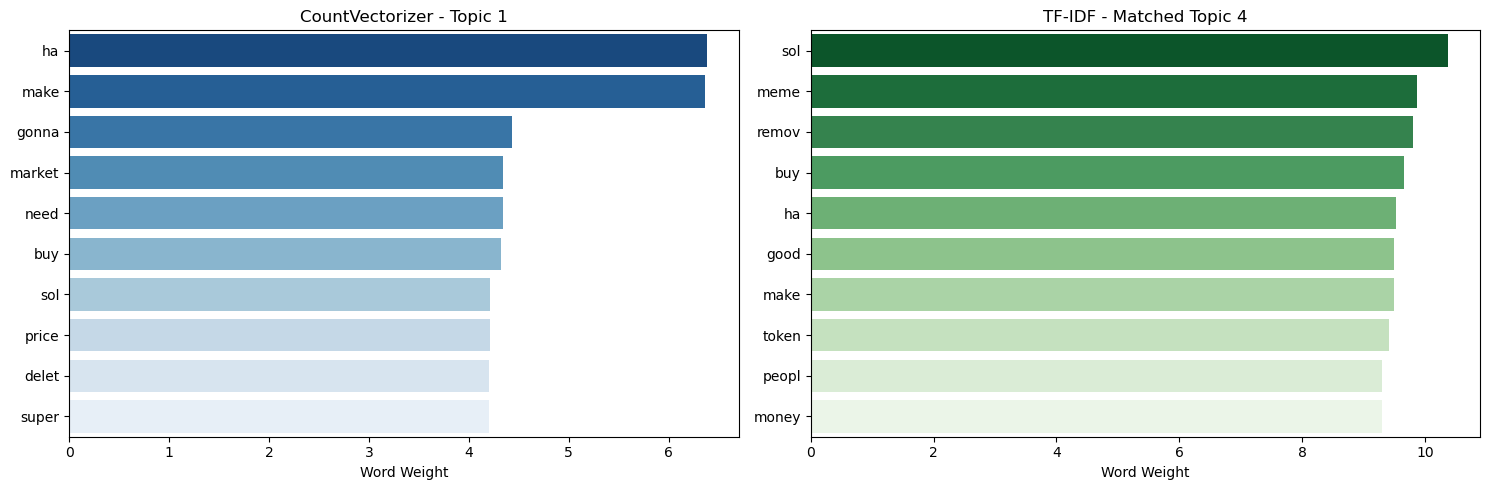

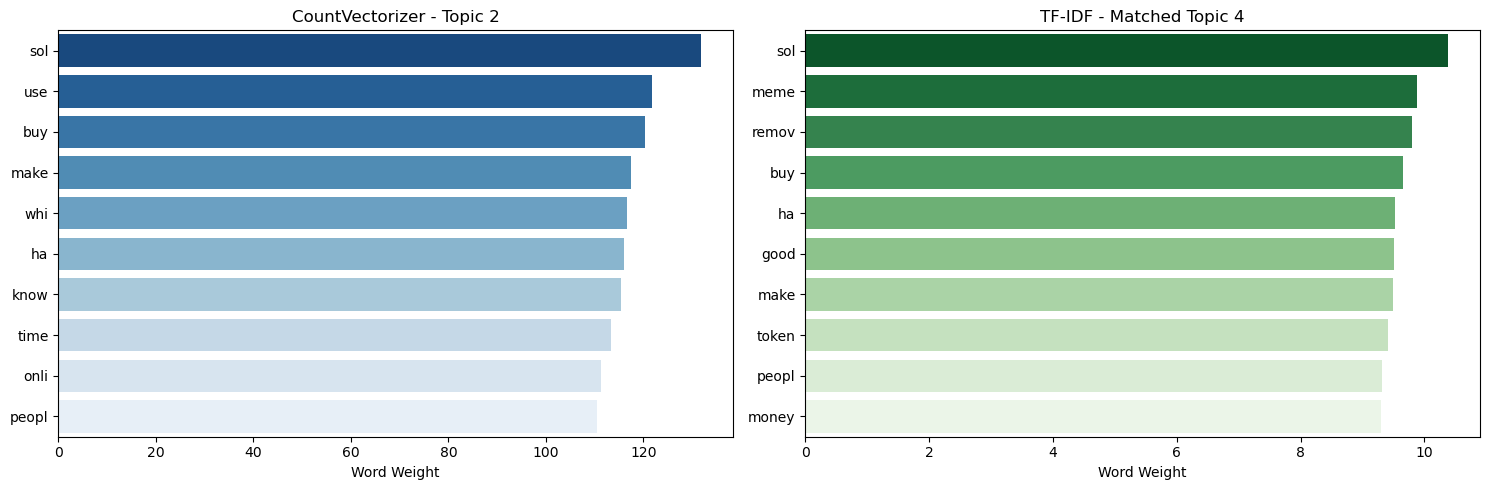

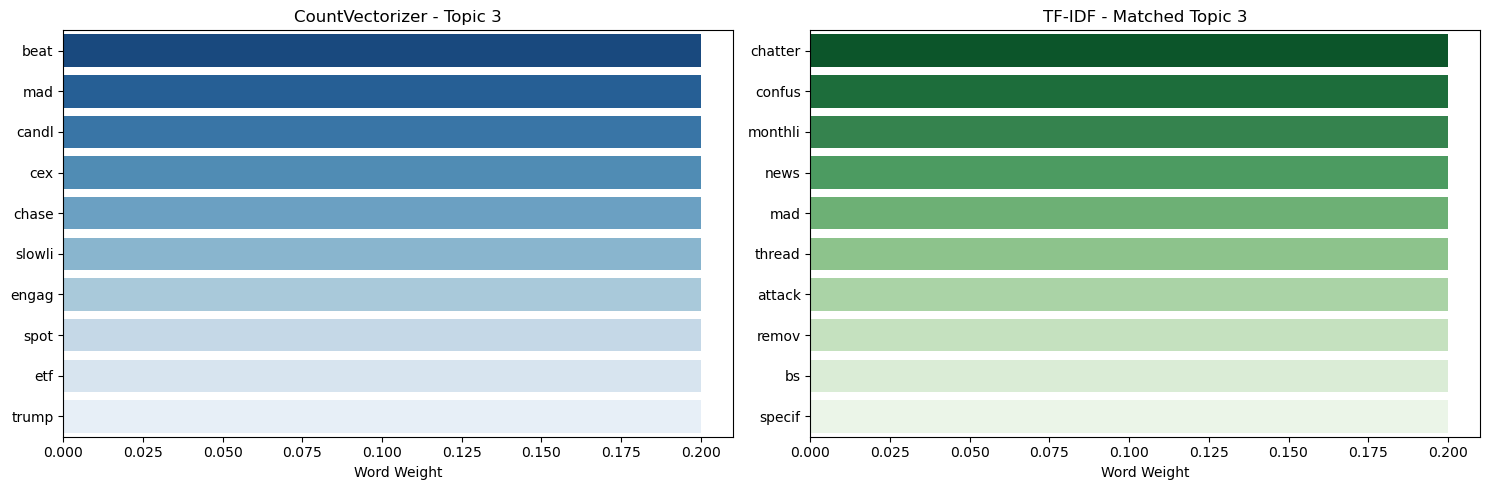

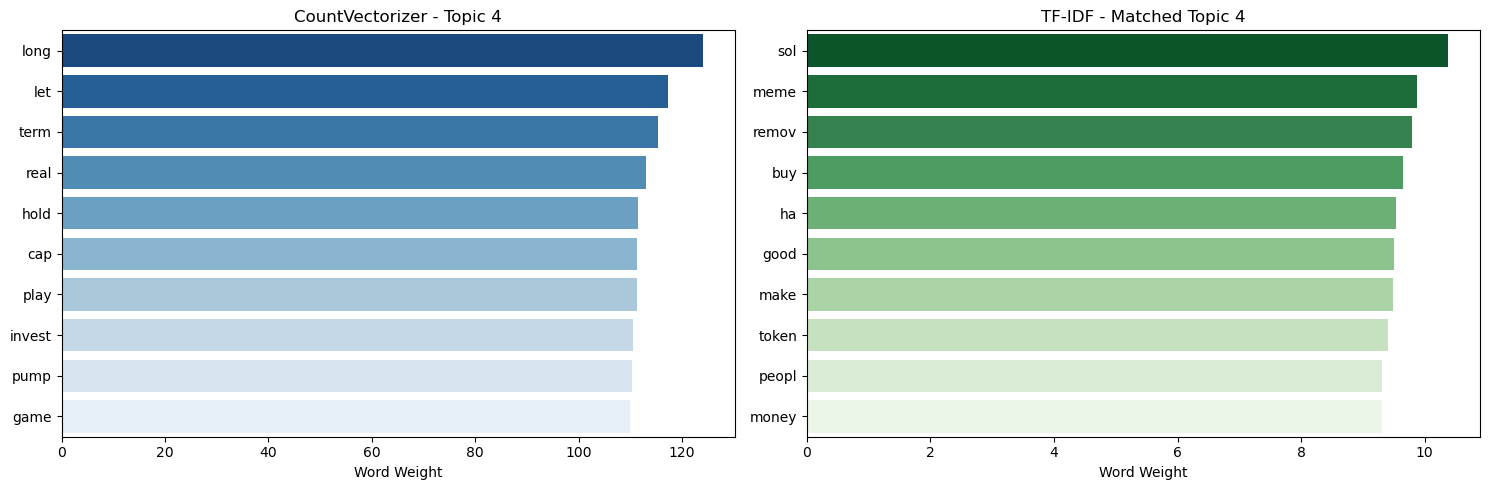

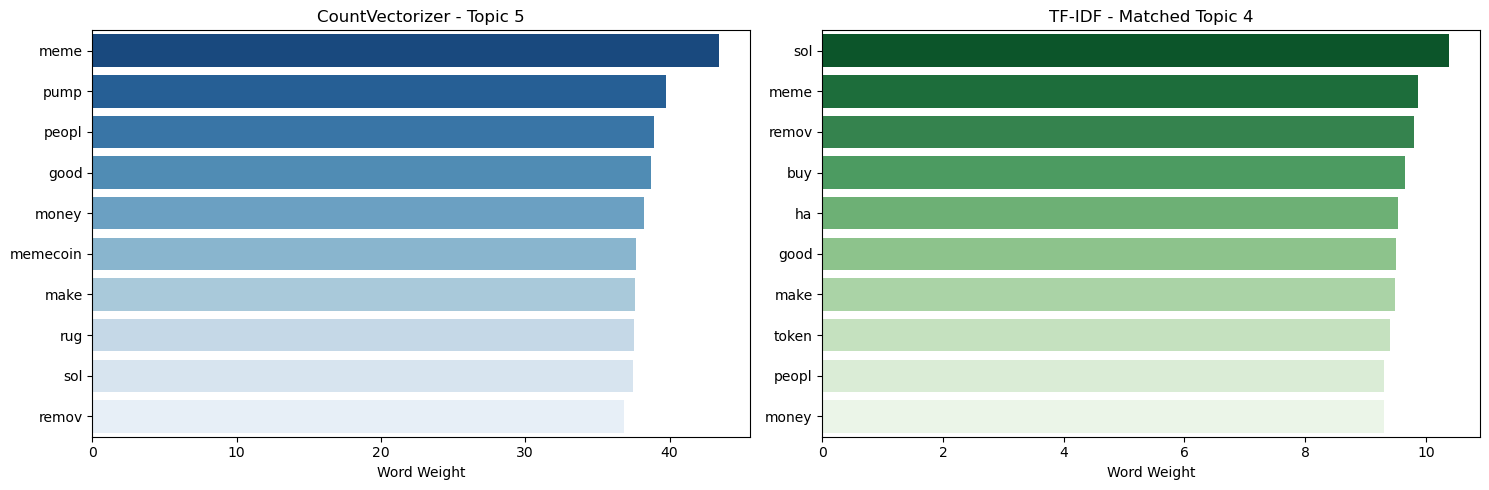

In [72]:
compare_matched_topics(lda_cv, lda_tfidf, cv_vectorizer, tfidf_vectorizer, topic_mapping)


In [73]:
def plot_wordclouds_for_both_models(lda1, vec1, lda2, vec2, title1="CountVectorizer", title2="TF-IDF", top_n=30):
    
    

    feature_names1 = vec1.get_feature_names_out()
    feature_names2 = vec2.get_feature_names_out()
    n_topics = lda1.n_components  # assuming both models have same number of topics

    ncols = 2
    nrows = n_topics
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, n_topics * 3))

    for i in range(n_topics):
        # CountVectorizer model
        topic1 = lda1.components_[i]
        top_indices1 = topic1.argsort()[:-top_n - 1:-1]
        freqs1 = {feature_names1[j]: topic1[j] for j in top_indices1}
        wc1 = WordCloud(width=400, height=300, background_color='black', colormap='plasma').generate_from_frequencies(freqs1)

        axes[i, 0].imshow(wc1, interpolation='bilinear')
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"{title1} - Topic {i+1}")

        # TF-IDF model
        topic2 = lda2.components_[i]
        top_indices2 = topic2.argsort()[:-top_n - 1:-1]
        freqs2 = {feature_names2[j]: topic2[j] for j in top_indices2}
        wc2 = WordCloud(width=400, height=300, background_color='black', colormap='viridis').generate_from_frequencies(freqs2)

        axes[i, 1].imshow(wc2, interpolation='bilinear')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"{title2} - Topic {i+1}")

    plt.tight_layout()
    plt.show()


### Word Clouds for Topic Visualization
We created word clouds for each topic extracted from the LDA models. These visualizations highlight the most significant terms associated with each topic, providing an intuitive understanding of the themes discussed in the subreddit. The word clouds are generated using the top 10 words for each topic, with larger words indicating higher importance.

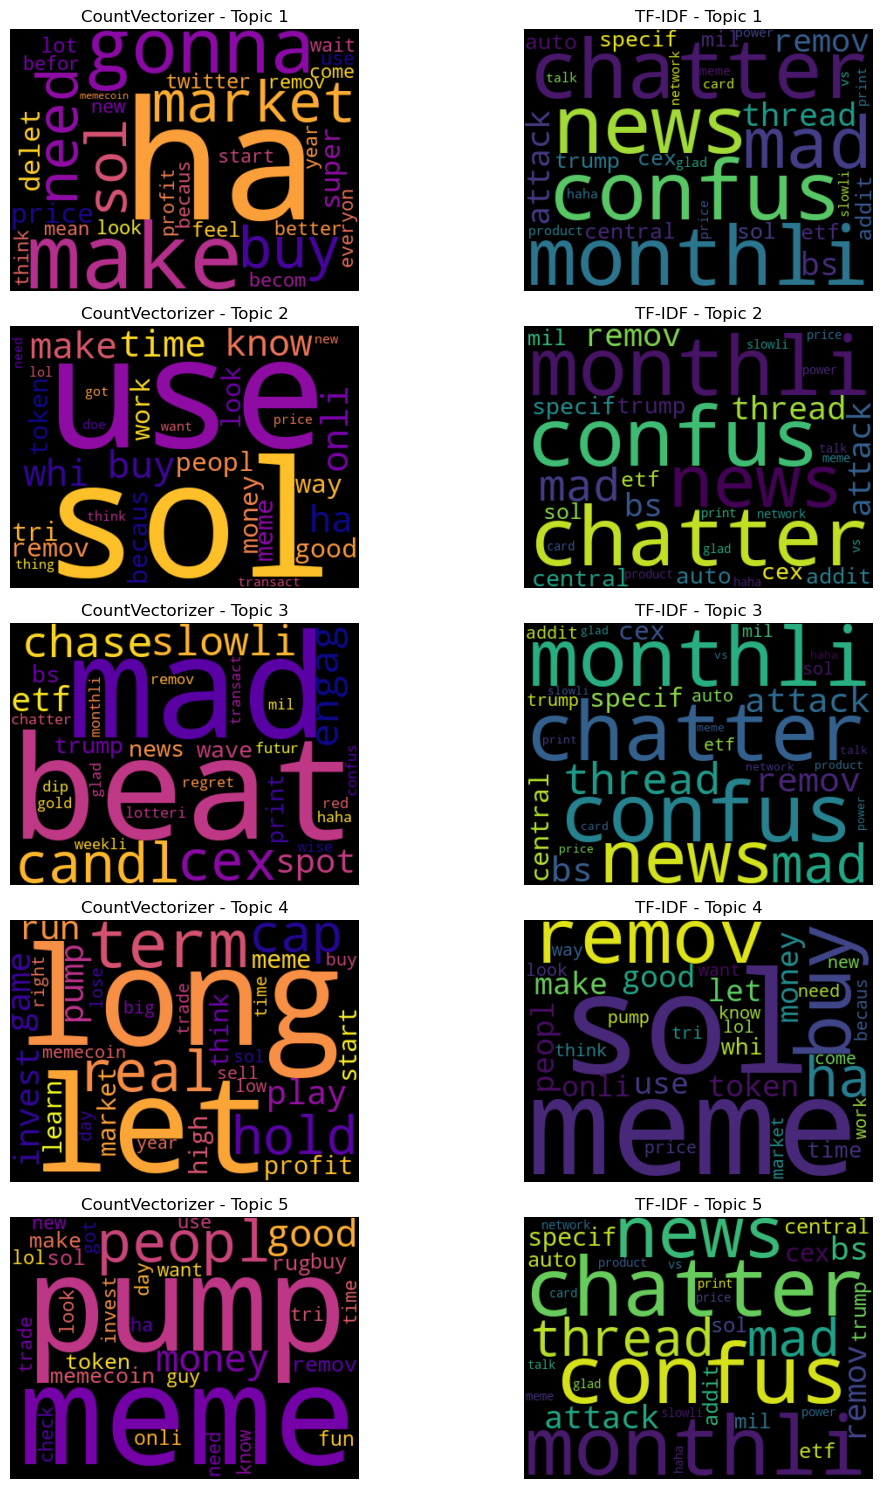

In [74]:
plot_wordclouds_for_both_models(
    lda1=lda_cv,
    vec1=cv_vectorizer,
    lda2=lda_tfidf,
    vec2=tfidf_vectorizer,
    title1="CountVectorizer",
    title2="TF-IDF"
)


In [79]:
#import as json top 100 samples
with open("solana_top_year_300posts_12comments.json", "r", encoding="utf-8") as f:
    data = json.load(f)
df = pd.DataFrame(data)
# Select top 100 posts
df_top_100 = df.nlargest(100, 'score')
# Save to JSON
df_top_100.to_json("solana_top_100_posts.json", orient="records", lines=True, force_ascii=False)